# Table 2 Measure of Illiquidity

This notebook walks through illiquidity calculations based on methodology in The Illiquidity of Corporate Bonds, Bao, Pan, and Wang (2010). In the paper, calculations are based on corporate bond data from 2003-04-14 to 2009-06-30.

  - In order to avoid re-running the notebook every time it changes (it changes often, even by the act of opening it) and to only rerun it if meaningful changes have been made, the build system only looks for changes in the plaintext version of the notebook. That is, the notebook is converted to a Python script via [nbconvert](https://nbconvert.readthedocs.io/en/latest/), which is often packaged with Jupyter.
  Then, DoIt looks for changes to the Python version. If it detects a difference, then the notebook is re-run. (Note, that you could also convert to a Markdown file with 
  [JupyText](https://github.com/mwouts/jupytext). However, this package is often not packaged with Jupyter.)
  - Since we want to use Jupyter Notebooks for exploratory reports, we want to keep fully-computed versions of the notebook (with the output intact). However, earlier I said that I strip the notebook of its output before committing to version control. Well, to keep the output, every time PyDoit runs the notebook, it outputs an HTML version of the freshly run notebook and saves that HTML report in the `output` directory. That way, you will be able to view the finished report at any time without having to open Jupyter.

### <font color='purple'>Overview of Outputs

#### * Table 2 Measure of Illiquidity:
- ##### Panel A Individual Bonds (The mean and average monthly illiquidity per bond per year)
    - Using trade-by-trade data
    - Using daily data
- ##### Panel B Bond Portfolio
    - Equal-weighted: Consider a daily portfolio composed of all bonds, with equally weighted bond returns used to calculate annual illiquidity
    - Issuance-weighted: Consider a daily portfolio composed of all bonds, with issuance weighted bond returns used to calculate annual illiquidity
- ##### Panel C Implied by quoted bid-ask spread
    - Mean and median monthly bond bid-ask spread per year

#### * Summary Statistics of Monthly Per Bond Illiquidity Using Daily Data
#### * Panel A and Summary Statistics Using MMN corrected data
#### * Replicate the Tables in the Paper (2003-04-14 to 2009-06-30) 
#### * Update the Tables to the present (2003-04-14 to present)
#### 

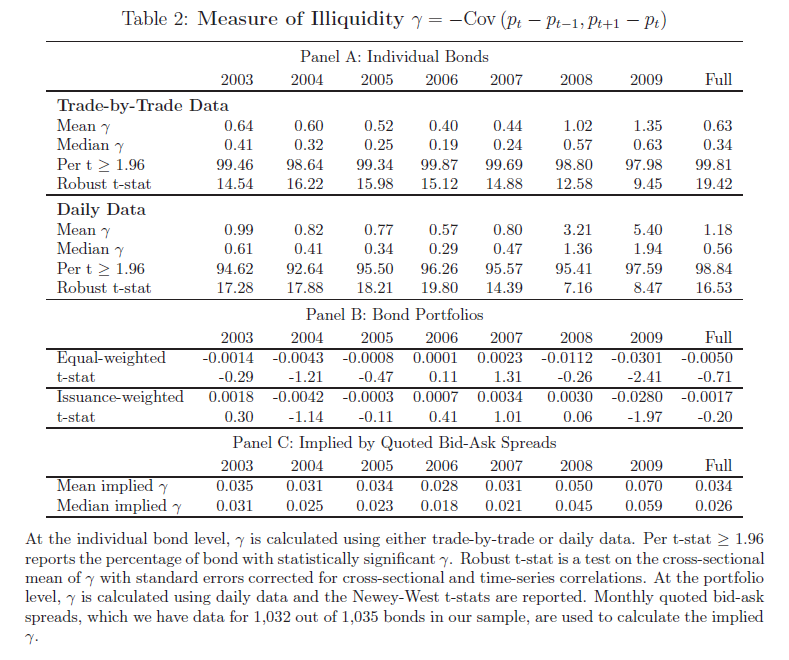

In [8]:
from IPython.display import Image
Image("../assets/table2_screenshot.jpg")

In [9]:
import config

OUTPUT_DIR = config.OUTPUT_DIR
DATA_DIR = config.DATA_DIR

In [46]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from datetime import datetime
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tools.tools import add_constant
import config

import warnings
warnings.filterwarnings('ignore')

In [11]:
import misc_tools
import load_wrds_bondret
import load_opensource
import data_processing as data
import table2_calc_illiquidity as calc_illiquidity
import table2_plot_illiquidity as plot

In [12]:
# Define time frames used in the paper and the updated time stamp
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2003-04-14'
end_date = '2009-06-30' 

# Step 1: Clean Merged Data for Daily Illiquidity Calculation

Before calculating illiquidity measures, it's essential to ensure that our corporate bond data is accurate and relevant. The `clean_merged_data` function takes care of preparing the pre-cleaned merged monthly and daily data by performing several critical cleaning steps:

- Loads and merges the relevant datasets within the specified date range.
- Removes any records with missing crucial price information and sorts the data chronologically.
- Adjusts for trade execution dates by incorporating a time lag to identify consecutive trades for the same bond, and filters out those that do not fall within a one-week window, accounting for holidays.
- Consolidates the cleaned data, readying it for the subsequent illiquidity analysis.

This step is crucial to ensure that the subsequent calculations are based on a dataset that reflects true trading activity without distortions from missing data or trades too far apart in time.


In [13]:
cleaned_df_paper = calc_illiquidity.clean_merged_data(start_date, end_date)
cleaned_df_paper.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,first_interest_date,last_interest_date,ncoups,amount_outstanding,n_mr,tmt,year,month_year,trd_exctn_dt_lag,n
602,36962GUR3,2003-04-15,105.974001,109.256640,3.282639,18.185417,21.468056,0.014644,0.014644,2500000.0,...,2000-11-03,2003-11-03,2.0,700000.0,1.0,1.025000,2003,2003-04,2003-04-14,1.0
603,370442AR6,2003-04-15,95.332902,96.237346,0.904444,55.335556,56.240000,0.078446,0.078446,889000.0,...,1996-03-01,2025-03-01,2.0,500000.0,7.0,22.666667,2003,2003-04,2003-04-14,1.0
604,92344SAE0,2003-04-15,106.907199,108.713796,1.806597,2.672569,4.479167,0.033530,0.033530,9000000.0,...,2002-12-15,2006-06-15,2.0,2446000.0,7.0,3.680556,2003,2003-04,2003-04-14,1.0
605,949746CC3,2003-04-15,111.335999,112.403360,1.067361,18.125000,19.192361,0.022727,0.022727,50000000.0,...,2001-02-24,2005-02-24,2.0,1000000.0,3.0,2.352778,2003,2003-04,2003-04-14,1.0
606,46625HAV2,2003-04-15,101.786597,102.608819,0.822222,0.033333,0.855556,0.035897,0.035897,22750000.0,...,2003-08-01,2007-08-01,2.0,1000000.0,5.0,4.827778,2003,2003-04,2003-04-14,1.0


In [14]:
cleaned_df_new = calc_illiquidity.clean_merged_data(start_date, today)
cleaned_df_new.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,first_interest_date,last_interest_date,ncoups,amount_outstanding,n_mr,tmt,year,month_year,trd_exctn_dt_lag,n
582,285659AD0,2003-04-15,104.698901,104.736956,0.038056,24.032083,24.070139,0.035922,0.035922,7367000.0,...,2000-04-15,2004-04-15,2.0,500000.0,9.0,1.483333,2003,2003-04,2003-04-14,1.0
584,36962GYZ1,2003-04-15,107.309301,108.989857,1.680556,2.625000,4.305556,0.031125,0.031125,7759000.0,...,2002-12-15,2006-12-15,2.0,2250000.0,1.0,4.186111,2003,2003-04,2003-04-14,1.0
586,073902AZ1,2003-04-15,112.397798,113.253353,0.855556,42.116667,42.972222,0.035438,0.035438,210000.0,...,1997-09-01,2006-09-01,2.0,350000.0,6.0,3.891667,2003,2003-04,2003-04-14,1.0
587,079867AH0,2003-04-15,109.513498,111.014887,1.501389,54.262153,55.763542,0.040033,0.040033,924000.0,...,1994-01-15,2008-07-15,2.0,350000.0,4.0,5.797222,2003,2003-04,2003-04-14,1.0
588,345397ST1,2003-04-15,98.635997,101.282872,2.646875,19.731250,22.378125,0.081268,0.081268,9477000.0,...,2000-12-15,2009-12-15,2.0,2500000.0,7.0,7.230556,2003,2003-04,2003-04-14,1.0


# Step 2: Calculate Price Changes and Perform Additional Cleaning

In this part of the analysis pipeline, we use the `calc_deltaprc` function to compute daily price changes for corporate bonds, designed to operate on cleaned and merged daily corporate bond trade data.

This calculation is based on the Measure of Illiquidity on page 10 and 11 of the peper: $ \gamma = -\text{Cov}(p_t - p_{t-1}, p_{t+1} - p_t) $. The process involves several steps:
- Calculation of Log Prices: Transform cleaned prices to log prices for more stable numerical properties.
- Lagged and Lead Price Changes: Determine the price changes by computing lagged and lead log prices.
- Restricting Returns: Ensure that calculated price changes (returns) are within the range of -100% to 100%.
- Conversion to Percentage: Change the representation of price changes from decimal to percentage for clarity.
- Cleaning Data: Remove entries with incomplete information to maintain the quality of the dataset.
- Filtering by Trade Count: Exclude bonds with fewer than 10 trade observations to focus on more reliable data.

This function is essential for preparing the bond price data for accurate calculation of financial metrics such as illiquidity.


In [15]:
# Calculate price change data using periods in the paper
df_paper = calc_illiquidity.calc_deltaprc(cleaned_df_paper)
df_paper.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,tmt,year,month_year,trd_exctn_dt_lag,n,logprc,logprc_lag,deltap,logprc_lead,deltap_lag
1225,345397SQ7,2003-04-16,103.468001,104.176334,0.708333,22.520833,23.229167,0.055476,0.055476,10334000.0,...,1.902778,2003,2003-04,2003-04-15,1.0,4.639262,4.633919,0.534345,4.639275,0.001255
1226,370425RJ1,2003-04-16,104.210101,106.569545,2.359444,23.975000,26.334444,0.031076,0.031076,1003000.0,...,1.150000,2003,2003-04,2003-04-15,1.0,4.646409,4.646475,-0.006620,4.647230,0.082107
1227,260543BU6,2003-04-16,103.132500,105.201945,2.069444,0.000000,2.069444,0.042376,0.042376,1035000.0,...,4.611111,2003,2003-04,2003-04-15,1.0,4.636015,4.627253,0.876200,4.629933,-0.608155
1228,191219BF0,2003-04-16,111.127899,113.843177,2.715278,22.984028,25.699306,0.035189,0.035189,1130000.0,...,5.588889,2003,2003-04,2003-04-15,1.0,4.710682,4.692768,1.791380,4.695206,-1.547620
1229,37042GD52,2003-04-16,96.987273,97.108107,0.120833,4.450694,4.571528,0.075946,0.074771,25000.0,...,NaN,2003,2003-04,2003-04-15,1.0,4.574580,4.585009,-1.042888,4.574582,0.000207


In [16]:
# Calculate price change data using update-to-date periods
df_new = calc_illiquidity.calc_deltaprc(cleaned_df_new)
df_new.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,tmt,year,month_year,trd_exctn_dt_lag,n,logprc,logprc_lag,deltap,logprc_lead,deltap_lag
1185,079857AG3,2003-04-16,115.000004,116.356254,1.356250,23.293056,24.649306,0.051149,0.051149,10000.0,...,6.897222,2003,2003-04,2003-04-15,1.0,4.744932,4.785665,-4.073293,4.782680,3.774806
1186,00184AAD7,2003-04-16,104.440100,107.096350,2.656250,3.171875,5.828125,0.033443,0.033443,6203000.0,...,2.033333,2003,2003-04,2003-04-15,1.0,4.648614,4.647722,0.089183,4.650268,0.165414
1187,38141GBU7,2003-04-16,111.903098,113.663098,1.760000,6.691667,8.451667,0.049072,0.049072,13649000.0,...,8.838889,2003,2003-04,2003-04-15,1.0,4.717633,4.713332,0.430137,4.721193,0.355922
1188,36962GZH0,2003-04-16,104.363098,104.799904,0.436806,2.222569,2.659375,0.038488,0.038488,1583000.0,...,6.472222,2003,2003-04,2003-04-15,1.0,4.647876,4.649814,-0.193753,4.650259,0.238308
1189,025816AK5,2003-04-16,105.940000,108.152500,2.212500,37.125000,39.337500,0.016117,0.016117,4460000.0,...,1.166667,2003,2003-04,2003-04-15,1.0,4.662873,4.658340,0.453262,4.661254,-0.161921


# Step 3: Panel A Individual Bond: Illiquidity Metrics Calculation Using Daily Bond Data

This step involves using the `calc_annual_illiquidity_table_daily` function to calculate and summarize annual illiquidity metrics for corporate bonds. The function takes daily bond data as input and computes several statistics that capture the illiquidity of bonds on an annual basis. `create_annual_illiquidity_table` function is used as the last step in `calc_annual_illiquidity_table_daily` to generate illiquidity table with significance percentage, robust t-stat, mean and median. 

- Computes the illiquidity for each bond by month by taking the negative of the covariance between daily price changes (`deltap`) and their lagged values (`deltap_lag`).

- Aggregated the monthly illiquidity measures to obtain annual statistics, including mean and median illiquidity.

- Calculates t-statistics for the mean illiquidity of each bond and year and determines the percentage of these t-stats that are significant (>= 1.96).

- Calculates robust t-stats are calculated using OLS with HAC (heteroskedasticity and autocorrelation consistent) standard errors.

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean and median illiquidity, the percentage of significant t-statistics, and robust t-statistics for each year, as well as for the full sample period.

This comprehensive illiquidity metric calculation allows us to understand the annual and overall liquidity characteristics of the corporate bond market.

In [17]:
# Replicate table 2 panel A daily data in the paper
illiq_daily_paper, table2_daily_paper = calc_illiquidity.calc_annual_illiquidity_table_daily(df_paper)
table2_daily_paper

100%|██████████| 47630/47630 [00:07<00:00, 6011.68it/s]


,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.012431,0.118649,77.283913,2.541571
1,2004,1.054907,0.061028,77.377015,10.183842
2,2005,0.851126,0.040949,80.297199,4.067339
3,2006,0.409025,0.036393,87.914056,6.715445
4,2007,1.116023,0.064962,87.326335,1.815385
5,2008,13.271568,0.232770,67.408497,20.787846
6,2009,17.980450,0.334487,69.007369,1.186281
7,Full,3.119932,0.072591,79.679268,17.057181


In [18]:
# Update table 2 panel A daily data to the present
illiq_daily_new, table2_daily_new = calc_illiquidity.calc_annual_illiquidity_table_daily(df_new)
table2_daily_new

100%|██████████| 62473/62473 [00:09<00:00, 6477.57it/s]


,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.013071,0.117607,77.850215,0.490985
1,2004,1.070753,0.060145,77.723404,6.150653
2,2005,0.843624,0.039453,80.766689,2.635933
3,2006,0.417981,0.034866,87.788779,0.984113
4,2007,1.128247,0.062519,87.945643,6.522312
5,2008,10.519394,0.219249,67.834456,0.374275
6,2009,4.010328,0.182663,73.894334,15.856989
7,2010,0.444072,0.051685,91.007616,40.595994
8,2011,0.379700,0.036848,82.629630,28.768055
9,2012,0.267179,0.041479,92.354884,0.140632


# Step 4: Summary Statistics Compilation Using Daily Illiquidity Data

This step entails utilizing the `create_summary_stats` function to compile key summary statistics that characterize daily illiquidity data for corporate bonds over different years--min, mean, median, max, 25%, 75% std monthly illiquidity per cusip and mean t-stat. This aids in understanding the distribution and central tendencies of bond illiquidity and t-statistics on an annual basis.

In [19]:
# Produce summary stats for per bond monthly illiquidity using periods in the paper
illiq_daily_summary_paper = calc_illiquidity.create_summary_stats(illiq_daily_paper)
illiq_daily_summary_paper

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-129.009527,1.012431,0.030657,0.118649,0.416826,1127.480854,15.926022,2.925198
1,2004,-6.984261,1.054907,0.014045,0.061028,0.242994,718.689577,17.546287,3.040041
2,2005,-12.645612,0.851126,0.009378,0.040949,0.171790,2116.809197,29.728685,3.109209
3,2006,-20.151911,0.409025,0.007929,0.036393,0.161738,787.236482,9.327834,3.437520
4,2007,-9.345427,1.116023,0.015308,0.064962,0.240230,1764.116960,26.605177,3.248946
5,2008,-830.664798,13.271568,0.059508,0.232770,1.132950,5836.747235,190.986134,2.517271
6,2009,-202.045271,17.980450,0.070607,0.334487,2.013726,8571.428571,233.059386,2.654317


In [20]:
# Examine outliers
illiq_daily_paper[illiq_daily_paper['illiq'] > 2000]

,cusip,month_year,illiq,year,t stat,significant
15350,247126AE5,2009-04,2780.997196,2009,1.176218,False
15370,247361YE2,2005-10,2116.809197,2005,1.020795,False
17130,26632QAH6,2008-01,2001.066833,2008,3.287915,True
17132,26632QAH6,2008-03,5434.541339,2008,3.287915,True
17133,26632QAH6,2008-04,5836.747235,2008,3.287915,True
17134,26632QAH6,2008-05,5758.264060,2008,3.287915,True
17138,26632QAH6,2008-09,3333.333371,2008,3.287915,True
17140,26632QAH6,2008-12,5714.285714,2008,3.287915,True
17160,26632QAK9,2008-06,2037.730503,2008,0.797720,False
27609,432848AS8,2008-12,3560.187974,2008,1.172602,False


In [21]:
# Produce summary stats for per bond monthly illiquidity using update-to-date periods
illiq_daily_summary_new = calc_illiquidity.create_summary_stats(illiq_daily_new)
illiq_daily_summary_new

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-129.009527,1.013071,0.030905,0.117607,0.407148,1127.480854,16.139634,2.929592
1,2004,-6.984261,1.070753,0.014037,0.060145,0.241248,718.689577,17.767299,3.051168
2,2005,-12.645612,0.843624,0.009305,0.039453,0.167497,2116.809197,30.102278,3.139655
3,2006,-20.151911,0.417981,0.007769,0.034866,0.155547,787.236482,9.478433,3.451152
4,2007,-8.932729,1.128247,0.014896,0.062519,0.226398,1764.116960,27.067324,3.264730
5,2008,-284.127247,10.519394,0.058612,0.219249,1.013677,5836.747235,172.631333,2.562620
6,2009,-162.993465,4.010328,0.041266,0.182663,1.104113,883.596573,23.289963,2.687941
7,2010,-32.626281,0.444072,0.015076,0.051685,0.242857,54.345286,2.248481,3.739615
8,2011,-2.394000,0.379700,0.010355,0.036848,0.216858,17.530678,1.235823,3.355690
9,2012,-20.161320,0.267179,0.009667,0.041479,0.219475,36.981744,1.474108,3.783989


# Step 5: Panel A Using MMN Corrected Daily Bond Data

Now, we apply similar calculation in Step 3 and 4 using MMN corrected daily bond data. Since the MMN corrected daily bond data contains illiquidty directly, `calc_illiq_w_mmn_corrected` performs cleaning on MMN corrected data and apply `create_annual_illiquidity_table` to generate the similar Panel A (daily data) illiquidity final table, ready for comparison. We then use the in Step 4 to produce summary stats using cleaned MMN corrected daily bond data.

In [22]:
# Replicate table 2 panel A daily data in the paper using MMN corrected data
mmn_paper, table2_daily_mmn_paper = calc_illiquidity.calc_illiq_w_mmn_corrected(
    start_date, end_date, cleaned_df_paper)
table2_daily_mmn_paper

,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.126366,0.107766,71.480204,2.304529
1,2004,1.351033,0.061672,71.377686,10.106060
2,2005,0.433418,0.045342,79.905201,5.575357
3,2006,0.329079,0.045745,83.898432,0.497943
4,2007,0.403477,0.080262,88.265670,0.774973
5,2008,4.387134,0.269606,61.268378,10.143215
6,2009,8.436064,0.424655,63.152455,0.823691
7,Full,1.507753,0.078402,75.995184,7.206051


In [23]:
# Produce summary stats for per bond monthly illiquidity using periods in the paper using MMN corrected data
illiq_daily_summary_mmn_paper = calc_illiquidity.create_summary_stats(mmn_paper)
illiq_daily_summary_mmn_paper

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-9.143287,1.126366,0.025527,0.107766,0.345540,751.217416,16.797166,2.733560
1,2004,-20.038684,1.351033,0.013673,0.061672,0.247137,778.589263,21.198697,2.832352
2,2005,-18.137484,0.433418,0.010328,0.045342,0.178552,926.156664,12.341459,2.995291
3,2006,-40.331088,0.329079,0.010483,0.045745,0.167151,550.736267,7.142692,3.299684
4,2007,-4.427193,0.403477,0.022036,0.080262,0.272474,500.221470,6.729276,3.223165
5,2008,-249.784908,4.387134,0.065605,0.269606,1.129595,1084.715175,34.324809,2.246503
6,2009,-73.678064,8.436064,0.086623,0.424655,2.289379,925.409177,46.130775,2.377221


In [24]:
mmn_paper.head()

,Unnamed: 0,date,cusip,exretn_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,...,BONDPRC,PRFULL,DURATION,CONVEXITY,bond_value,BOND_VALUE,year,illiq,t stat,significant
27967,27967,2003-04-30,001546AE0,-0.063575,-0.082483,-0.062675,-0.023885,-0.024885,-0.025599,12.0,...,92.6618,94.258673,4.427331,24.702911,40122632.0,41697810.0,2003,0.647163,2.245310,True
27978,27978,2003-04-30,00184AAA3,0.017444,0.009376,0.018344,0.043164,0.042164,0.041512,8.0,...,107.1509,107.423125,2.706638,8.983116,107524651.0,107150900.0,2003,0.175779,2.033155,True
27979,27979,2003-04-30,00184AAB1,0.050186,0.020915,0.051086,0.025243,0.024243,0.023114,8.0,...,107.8086,108.108602,6.168393,46.752979,108353755.0,107808600.0,2003,0.071140,1.487224,False
27980,27980,2003-04-30,00184AAC9,0.082945,0.037654,0.083845,0.021796,0.020796,0.019919,8.0,...,109.0437,109.382588,12.075853,231.670907,216107272.0,218087400.0,2003,-0.163314,1.816756,False
27981,27981,2003-04-30,00184AAD7,0.010570,0.007493,0.011470,0.010952,0.009952,0.009416,8.0,...,103.5500,103.549999,1.888003,4.574499,105078814.0,103550000.0,2003,0.069521,3.025802,True


In [25]:
# Update table 2 panel A daily data to the present using MMN corrected data
mmn_new, table2_daily_mmn_new = calc_illiquidity.calc_illiq_w_mmn_corrected(
    start_date, today, cleaned_df_new)
table2_daily_mmn_new

,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.263910,0.110032,72.102718,8.033270
1,2004,1.495441,0.064419,71.634726,2.312737
2,2005,0.465774,0.046236,79.585983,4.800168
3,2006,0.342268,0.046322,83.994630,1.502008
4,2007,0.414206,0.082518,89.803157,9.309214
5,2008,4.418317,0.269047,60.336279,48.436547
6,2009,4.661818,0.227257,70.217853,50.570631
7,2010,0.247482,0.066234,88.923077,6.462690
8,2011,0.288858,0.047112,79.589041,12.204280
9,2012,0.280102,0.066420,90.576271,1.246858


In [26]:
# Produce summary stats for per bond monthly illiquidity using update-to-date periods using MMN corrected data
illiq_daily_summary_mmn_new = calc_illiquidity.create_summary_stats(mmn_new)
illiq_daily_summary_mmn_new

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-9.357964,1.263910,0.026446,0.110032,0.361274,767.255311,19.564480,2.756077
1,2004,-20.038684,1.495441,0.014128,0.064419,0.260289,778.589263,23.087278,2.846538
2,2005,-18.137484,0.465774,0.010503,0.046236,0.185411,926.156664,12.357977,3.018792
3,2006,-40.331088,0.342268,0.010857,0.046322,0.172629,550.736267,7.142619,3.312651
4,2007,-1.784522,0.414206,0.022977,0.082518,0.280699,500.221470,6.718872,3.258224
5,2008,-249.784908,4.418317,0.065406,0.269047,1.099317,1084.715175,34.908861,2.268795
6,2009,-73.678064,4.661818,0.051912,0.227257,1.125256,925.409177,32.378854,2.473155
7,2010,-6.315249,0.247482,0.019890,0.066234,0.217277,19.621526,0.710688,3.439110
8,2011,-11.126745,0.288858,0.012429,0.047112,0.226043,19.924739,1.073702,3.175623
9,2012,-1.646094,0.280102,0.016928,0.066420,0.270844,26.350945,0.867468,3.707704


# Step 6: Panel B Bond Portfolios: Portfolio-Based Annual Illiquidity Metrics Calculation

The `calc_annual_illiquidity_table_portfolio` function computes the illiquidity metrics for corporate bonds by constructing equal-weighted and issuance-weighted portfolio returns on a daily basis and then calculate portfolio illiquidity on an annual basis. The function systematically processes transaction-level bond data to assess market liquidity through portfolio aggregation, offering a more holistic view of the market dynamics. 

- Equal-Weighted Portfolio Calculation: Creat an equal-weighted portfolio for each trading day by averaging the daily price changes (deltap) and their lagged values (deltap_lag). It then groups these daily averages by year to calculate the negative covariance between the deltap and deltap_lag to derive the illiquidity measure for each year. Additionally, a t-statistic for the mean illiquidity of the equal-weighted portfolio is computed.

- Issuance-Weighted Portfolio Calculation: Each bond is calculated with its $ \text{issuance} = \text{offering amount} \times \text{principal amount} \times \text{offering price} / 100 / 1,000,000 $ , and all bonds deltap and deltap_lag are aggregated on a daily basis weighted by issurance. The following steps are similar to Equal-Weighted Portfolio Calculation.

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean equal_weighted portfolio and t-stat, mean issuance-weighted portfolio illiquidity and t-stat for each year, as well as for the full sample period.

In [27]:
# Replicate table 2 panel B in the paper
table2_port_paper = calc_illiquidity.calc_annual_illiquidity_table_portfolio(df_paper)
table2_port_paper

100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


,Year,Equal weighted,EW t stat,Issuance weighted,IW t stat
0,2003,-0.006087,-0.294912,-0.009461,-0.432602
1,2004,-0.004753,-0.331050,-0.005822,-0.388742
2,2005,-0.003060,-0.249180,-0.003177,-0.322195
3,2006,-0.001192,-0.146704,-0.000798,-0.091350
4,2007,0.003547,0.361148,0.000779,0.084557
5,2008,-0.069819,-1.338890,-0.061089,-1.608162
6,2009,-0.089945,-1.818492,-0.050784,-1.657787
7,Full,-0.021060,-2.047658,-0.016470,-2.087139


In [28]:
# Update table 2 panel B to the present
table2_port_new = calc_illiquidity.calc_annual_illiquidity_table_portfolio(df_new)
table2_port_new

100%|██████████| 1/1 [00:00<00:00, 499.08it/s]


,Year,Equal weighted,EW t stat,Issuance weighted,IW t stat
0,2003,-0.005845,-0.287913,-0.009244,-0.428517
1,2004,-0.004080,-0.286979,-0.005679,-0.382232
2,2005,-0.004104,-0.349774,-0.003013,-0.310542
3,2006,-0.001127,-0.142187,-0.000867,-0.101504
4,2007,0.003344,0.355136,0.000443,0.049224
5,2008,-0.063465,-1.368612,-0.056569,-1.476951
6,2009,-0.045348,-1.739606,-0.025759,-1.550818
7,2010,-0.007239,-0.675527,-0.000621,-0.074399
8,2011,-0.001047,-0.105002,-0.002195,-0.243810
9,2012,0.002553,0.261910,0.006512,0.583311


# Step 7: Panel C Implied by Quoted Bid-Ask Spreads: Annual Implied Illiquidity Using Monthly Quoted Bid-Ask Spread

In this section, we focus on analyzing the illiquidity implied by quoted bid-ask spreads of corporate bonds on an annual basis using `calc_annual_illiquidity_table_spd`. 


- For each year, calculates the mean and median of the monthly `t_spread`, which represent the implied gamma. 

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean and median implied illiquidity for each year, as well as for the full sample period.

By computing these statistics, the function provides insights into the liquidity of the corporate bond market as implied by the bid-ask spreads over time. As shown in the paper, not only does the quoted bid-ask spread fail to capture the overall level of illiquidity, but it also fails to explain the cross-sectional variation in bond illiquidity and its asset pricing implications.

In [29]:
# Replicate table 2 panel C in the paper
table2_spd_paper = calc_illiquidity.calc_annual_illiquidity_table_spd(df_paper) 
table2_spd_paper

,Year,Mean implied gamma,Median implied gamma
0,2003,0.006595,0.004536
1,2004,0.005371,0.003603
2,2005,0.004684,0.003305
3,2006,0.004274,0.003142
4,2007,0.005705,0.004373
5,2008,0.012404,0.008957
6,2009,0.015906,0.012258
7,Full,0.006560,0.004239


In [30]:
# Update table 2 panel C to the present
table2_spd_new = calc_illiquidity.calc_annual_illiquidity_table_spd(df_new) 
table2_spd_new

,Year,Mean implied gamma,Median implied gamma
0,2003,0.006659,0.004563
1,2004,0.005447,0.003603
2,2005,0.004749,0.003290
3,2006,0.004380,0.003110
4,2007,0.005767,0.004323
5,2008,0.012336,0.008892
6,2009,0.012398,0.009269
7,2010,0.006056,0.004523
8,2011,0.005425,0.003472
9,2012,0.005628,0.003654


# Step 8: Plot Monthly Illiquidity Per Bond and Average Illiquidity By Year

The `plot_illiquidity` function visualizes both monthly bond illquidity observations and annual trends. 

- Monthly Illiquidity Per Bond: This granular data paves the way for an in-depth examination of liquidity at the bond level, month by month, in scatter.

- Annual Illiquidity Summary Insights: Visualize Table 2 Panel 1 mean and median illiquidity using daily data, shown as the lines on the plot. Red line indicates the mean, purple line the median. Mean is much higher than median around ~2008-2009, suggesting high illquidity outliers.

- The Zoomed-In Analysis: Acknowledging the potential distortion by extreme values, the function prudently narrows down the focus in the second subplot. By honing in on a more typical range of illiquidity values, it effectively filters out the outliers, thereby furnishing a clearer, more focused analysis of the prevalent liquidity patterns.

We have used both original data and MMN corrected data to generate seperate plots.

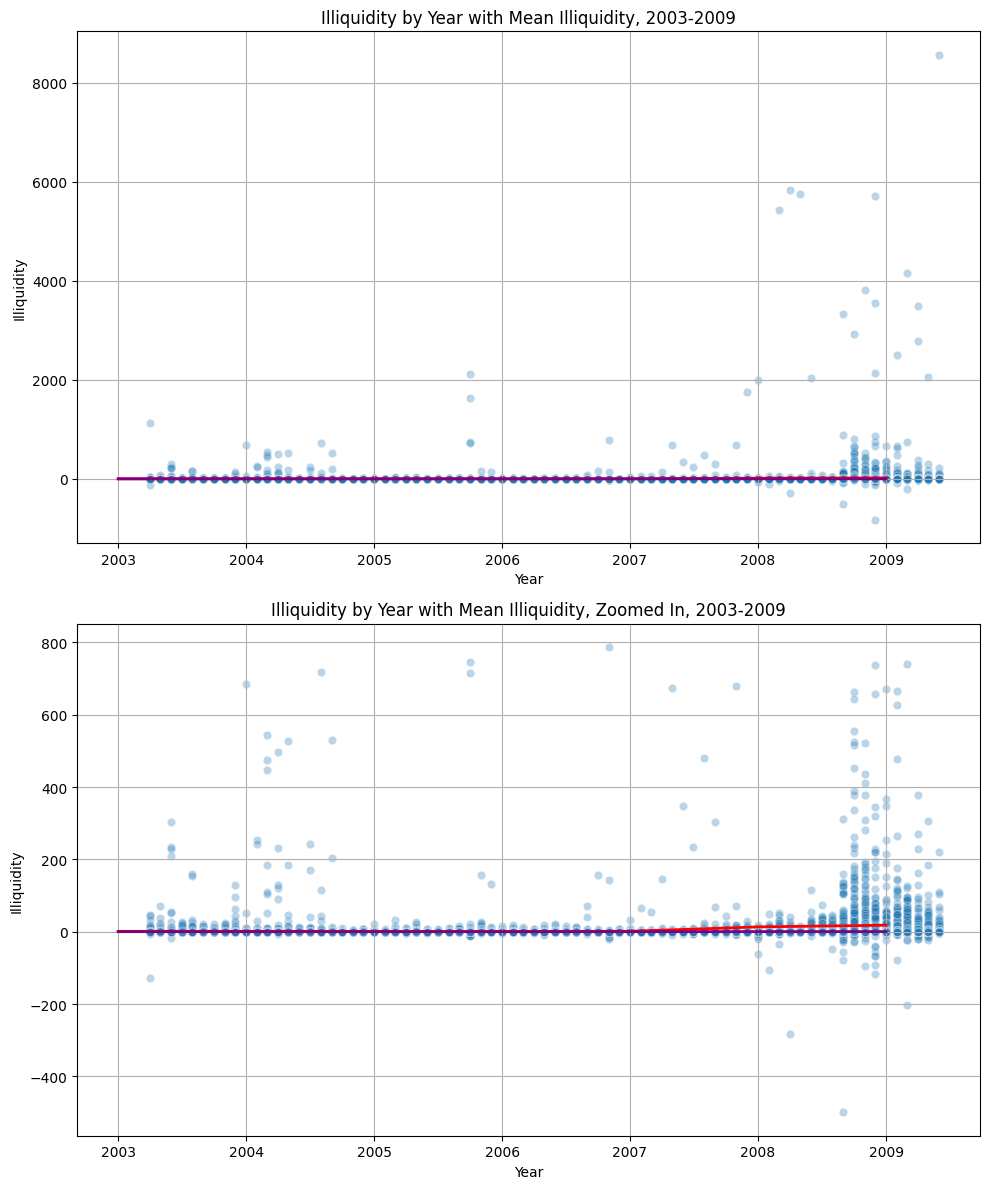

In [33]:
# Plot using original data, 2003-2009
illiq_daily_paper = pd.read_csv(OUTPUT_DIR / "illiq_daily_paper.csv")
illiq_daily_summary_paper = pd.read_csv(OUTPUT_DIR / "illiq_daily_summary_paper.csv")

plot.plot_illiquidity(illiq_daily_paper, illiq_daily_summary_paper, "2003-2009")

In [49]:
plot.plot_illiquidity_plotly(illiq_daily_paper, illiq_daily_summary_paper, '2003-2009')

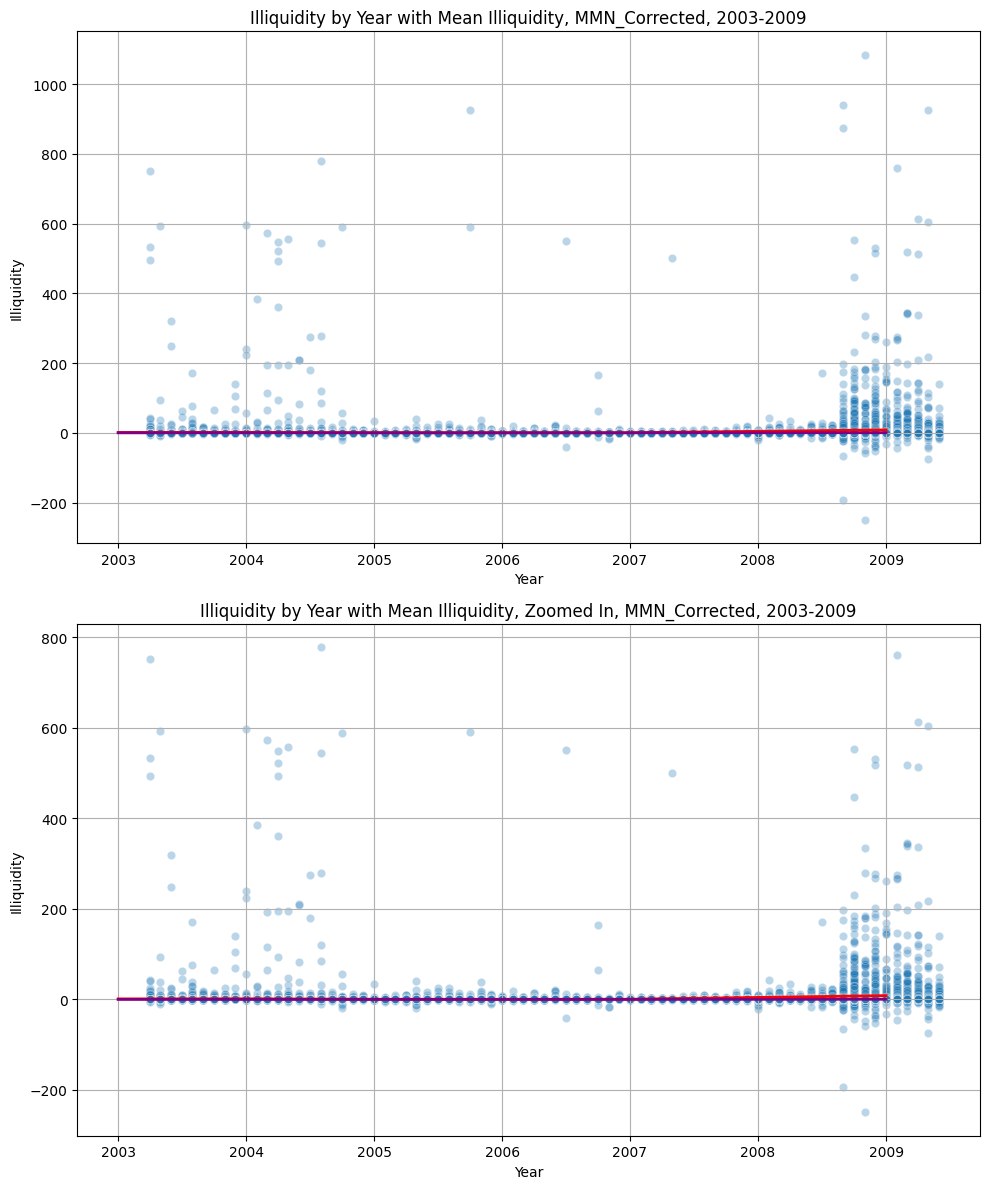

In [39]:
# Plot using original data, 2003-2023
mmn_paper = pd.read_csv(OUTPUT_DIR / "mmn_paper.csv")
illiq_daily_summary_mmn_paper = pd.read_csv(OUTPUT_DIR / "illiq_daily_summary_mmn_paper.csv")

plot.plot_illiquidity(mmn_paper, illiq_daily_summary_mmn_paper, "MMN_Corrected, 2003-2009")

In [ ]:
# Plot using MMN corrected data, 2003-2009
plot.plot_illiquidity(mmn_paper, illiq_daily_summary_mmn_paper, "MMN_Corrected, 2003-2009")

NameError: name 'plot' is not defined

In [ ]:
# Plot using MMN corrected data, 2003-2023
plot.plot_illiquidity(mmn_new, illiq_daily_summary_mmn_new, "MMN_Corrected, 2003-2023")